In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import random
import pandas as pd

Nous commençons par définir les paramètres du problème :
- q : Capacité maximale de chaque camion.
- omega : Coût fixe associé à l'utilisation d'un camion.

Une situation(ici récupéré de données réelles) est modélisé par une variable `state` contenant:la positions des clients et du dépôt ainsi que la quantité commandé par chaque client.

Par exemple:
```py
state = {
    "position": [
        
        (0, 0),  # Dépôt
        (5, 2),  # Client 1
        (3, -3), # Client 2
        (2, 2),  # Client 3
        # ... autres clients
    ],
    "orders": [0, 5, 10, 7, ...]  # Commandes (0 pour le dépôt)
}
```

Les solutions de livraison sont représenté sous forme de liste.
Pour les construires n'ayant pas d'impératif horaire on consièdre qu'un camion va de client en client,
juqu'a ce que sa capacité max soit atteinte. Il retourne alors au dépot et repart jusqu'a ce que tout les clients soient livrés. Au final qu'un camion réalise ces n tournées à la suite ou que n camion les réalise simultanement est équivalent.

Par exemple la solution [0,3,6,0,1,2,0] sinifie qu'un camion va livrer le client 3 puis 6 pendant qu'une autre va a 1 puis 2 (0 correspond au dépot).





Ensuite, nous définissons deux fonctions essentielles :
- `fitness()` : Évalue la qualité d'une solution (plus le score est bas, meilleure est la solution).
- `compute_distance_matrix()` : Calcule les distances entre tous les points du problème.

---


In [3]:
q = 400      # Capacité maximale des camions
omega = 10  # Coût fixe par camion utilisé

def fitness(state, solution, distance_matrix):
    """
    Calcule la fonction objectif d'une solution donnée.
    
    Args:
        state: Dictionnaire contenant les informations du problème
        solution: Liste d'entiers représentant l'ordre de visite des clients
        distance_matrix: Matrice des distances entre les points
        
    Returns:
        Valeur de la fonction objectif (coût total)
    """
    orders = state["orders"]

    delivered = set()
    capacity = q
    total_distance = 0
    
    penalty_count = 0  # Compteur de violations de contraintes
    penalty_factor = 1000  # Multiplicateur de pénalité

    trucks = 0

    for i in range(1, len(solution)):
        prev, curr = solution[i-1], solution[i]
        
        # Vérifier si le chemin existe
        if distance_matrix[prev, curr] == float("inf"):
            penalty_count += 6  # Le chemin n'existe pas

        total_distance += distance_matrix[prev, curr]
        
        # Si on est chez un client, livrer sa commande
        if curr != 0:  
            if capacity < orders[curr]:
                penalty_count += (orders[curr] - capacity + 1) // 2  # Capacité insuffisante
            
            capacity -= orders[curr]
            delivered.add(curr)
        
        # Si on est de retour au dépôt, recharger le camion
        if curr == 0:
            trucks += 1
            capacity = q

    # S'assurer que toutes les commandes sont livrées
    if len(delivered) < len(orders) - 1:  # En excluant le dépôt
        penalty_count += 5 * (len(orders) - 1 - len(delivered))  # Certaines commandes n'ont pas été livrées

    # S'assurer que le chemin commence et se termine au dépôt
    if solution[0] != 0 or solution[-1] != 0:
        penalty_count += 2  # La route ne commence/finit pas au dépôt

    # Score final: distance totale + coût des camions + pénalités
    trucks_value = trucks * omega
    penalty_value = penalty_count * penalty_factor
    return total_distance + trucks_value + penalty_value

def compute_distance_matrix(state):
    """
    Calcule la matrice des distances entre tous les points.
    
    Args:
        state: Dictionnaire contenant les positions des points
        
    Returns:
        Matrice des distances
    """
    coords = state["position"]
    n = len(coords)

    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt((coords[i][0] - coords[j][0])**2 + (coords[i][1] - coords[j][1])**2)
    return dist_matrix

Nous allons maintenant définir les fonctions nécessaires pour l'algorithme de recherche tabou :
- `load_data()` : Récupère et filtre les donnés.
- `construct_initial_solution()` : Crée une solution initiale valide.
- `count_trucks()` : Compte le nombre de camions utilisés dans une solution.
- `is_valid_solution()` : Vérifie si une solution respecte les contraintes de capacité.
- `tabu_search()` : Implémente l'algorithme de recherche tabou.
- `plot_solution()` : Visualise la solution sur un graphique.
- `plot_cost_evolution()` : Trace l'évolution des coûts pendant la recherche.
- ` plot_capacity_evolution(state, solution)` : Trace l'évolution des de la capcité d'camion.

---


In [21]:
def load_data(route_id=2946091):
    # Charger les fichiers Excel
    customers_df = pd.read_excel('database/2_detail_table_customers.xls')
    depots_df = pd.read_excel('database/4_detail_table_depots.xls')
    distances_df = pd.read_excel('database/6_detail_table_cust_depots_distances.xls')

    # Filtrer les données pour le ROUTE_ID spécifié
    customers_df = customers_df[customers_df['ROUTE_ID'] == route_id]
    depots_df = depots_df[depots_df['ROUTE_ID'] == route_id]
    distances_df = distances_df[distances_df['ROUTE_ID'] == route_id]

    # Extraire les informations des clients
    customer_positions = list(zip(customers_df['CUSTOMER_LATITUDE'], customers_df['CUSTOMER_LONGITUDE']))
    orders = list(map(int, customers_df['NUMBER_OF_ARTICLES']))

    # Extraire les informations des dépôts
    depot_positions = list(zip(depots_df['DEPOT_LATITUDE'], depots_df['DEPOT_LONGITUDE']))

    # Extraire les distances
    distances = {}
    for _, row in distances_df.iterrows():
        key = (row['DEPOT_CODE'], row['CUSTOMER_CODE'])
        distances[key] = row['DISTANCE_KM']

    # Créer la structure de données
    state = {
        "position": [depot_positions[0]] + customer_positions,  # Ajouter le dépôt en premier
        "orders": [0] + orders  # La demande du dépôt est 0
    }

    return state #, distances

def construct_initial_solution(state):
    """
    Génère une solution initiale en visitant les clients dans l'ordre, avec des retours au dépôt
    lorsque la capacité du camion est atteinte.
    """
    orders = state["orders"]
    solution = [0]  # Commence au dépôt
    current_load = 0

    for client_id in range(1, len(orders)):
        if current_load + orders[client_id] > q:  # Si la capacité est dépassée
            solution.append(0)  # Retour au dépôt
            current_load = 0  # Réinitialiser la charge
        solution.append(client_id)
        current_load += orders[client_id]

    solution.append(0)  # Retour final au dépôt
    return solution

def count_trucks(solution):
    """ Compte le nombre de camions utilisés (nombre de retours au dépôt) """
    return solution.count(0) - 1  # On retire le premier 0 (départ)

def is_valid_solution(solution, orders, capacity):
    """ Vérifie que chaque camion respecte sa capacité """
    total_load = 0
    for node in solution:
        if node == 0:  # Retour au dépôt -> Réinitialisation de la charge
            total_load = 0
        else:
            total_load += orders[node]
            if total_load > capacity:
                return False  # Dépassement de la capacité
    return True


def tabu_search(state, initial_solution, max_iter=100, tabu_tenure=5, neighborhood_size=20):
    distance_matrix = compute_distance_matrix(state)
    best_solution = initial_solution
    best_cost = fitness(state, best_solution, distance_matrix)
    tabu_list = []
    
    for iteration in range(max_iter):
        neighborhood = []

        # Générer un sous-ensemble de voisins avec des swaps
        for _ in range(neighborhood_size):
            i, j = random.sample(range(1, len(best_solution) - 1), 2)  # Choisir 2 clients aléatoires
            new_solution = best_solution[:]
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            
            if is_valid_solution(new_solution, state['orders'], q):
                cost = fitness(state, new_solution, distance_matrix)
                move = (i, j)
                neighborhood.append((new_solution, cost, move))
        
        if not neighborhood:
            print("Aucun voisin valide trouvé, arrêt de la recherche.")
            break

        # Trier les voisins par coût
        neighborhood.sort(key=lambda x: x[1])

        for candidate, cost, move in neighborhood:
            if move not in tabu_list or cost < best_cost:
                best_solution = candidate
                best_cost = cost
                tabu_list.append(move)
                
                if len(tabu_list) > tabu_tenure:
                    tabu_list.pop(0)

                if cost < best_cost:
                    best_cost = cost
                    tabu_list = []  # Réinitialisation de la liste tabou si une meilleure solution est trouvée
                break
    
    return best_solution, best_cost

def plot_solution(state, solution):
    positions = state["position"]
    depot = positions[0]
    clients = positions[1:]
    
    plt.figure(figsize=(12, 8))
    plt.scatter(*depot, c='red', marker='s', s=200, label='Dépôt')
    
    # Afficher seulement les clients avec des commandes importantes
    for i, (x, y) in enumerate(clients, start=1):
        if state['orders'][i] > 5:  # Afficher uniquement les clients avec plus de 5 articles
            plt.scatter(x, y, c='blue', s=50)
            plt.text(x, y, f"{i}\n(q={state['orders'][i]})", fontsize=8, verticalalignment='bottom', horizontalalignment='right')
        else:
            plt.scatter(x, y, c='blue', s=10)  # Points plus petits pour les autres clients
    
    colors = plt.cm.tab20.colors  # Palette de couleurs pour les camions
    truck_count = 0
    current_color = colors[truck_count % len(colors)]
    
    for i in range(len(solution) - 1):
        start, end = solution[i], solution[i + 1]
        if start == 0:  # Nouveau camion
            truck_count += 1
            current_color = colors[truck_count % len(colors)]
        plt.plot([positions[start][0], positions[end][0]], [positions[start][1], positions[end][1]], 
                 color=current_color, linewidth=1.5, marker='o', markersize=5)
    
    plt.legend()
    plt.title(f"Optimisation des tournées de véhicules - Nombre de camions : {truck_count}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

def plot_capacity_evolution(state, solution):
    """
    Trace l'évolution de la capacité des camions en fonction de la distance parcourue.
    
    Args:
        state: Dictionnaire contenant les informations du problème (positions et commandes).
        solution: Liste représentant la solution (ordre de visite des clients).
    """
    positions = state["position"]
    orders = state["orders"]
    distance_matrix = compute_distance_matrix(state)
    
    # Initialisation des variables
    current_load = 0
    total_distance = 0
    distances = [0]  # Distance cumulée
    capacities = [400]  # Charge du camion
    
    for i in range(len(solution) - 1):
        start, end = solution[i], solution[i + 1]
        distance = distance_matrix[start][end]
        total_distance += distance
        
        if start == 0:  # Départ du dépôt
            current_load = 0  # Réinitialiser la charge
        
        if end != 0:  # Si on est chez un client
            current_load += orders[end]
        
        distances.append(total_distance)
        capacities.append(400-current_load)
    
    # Tracer l'évolution de la capacité
    plt.figure(figsize=(10, 6))
    plt.plot(distances, capacities, marker='o', linestyle='-', color='b', label="Charge du camion")
    plt.axhline(y=q, color='r', linestyle='--', label="Capacité maximale du camion")
    
    # Ajouter des annotations pour les points clés
    for i, (dist, cap) in enumerate(zip(distances, capacities)):
        if i == 0 or i == len(distances) - 1 or cap == 0 or cap == q:
            plt.text(dist, cap, f"({dist:.2f} km, {cap} unités)", fontsize=9, ha='right')
    
    plt.xlabel("Distance parcourue (km)")
    plt.ylabel("Charge du camion (unités)")
    plt.title("Évolution de la capacité des camions durant la tournée")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()




## Explication de la Fonction `tabu_search`:
La fonction `tabu_search` implémente l'algorithme de recherche tabou.

L'algorithme de recherche tabou explore l'espace des solutions pour trouver une solution optimale (ou proche de l'optimum) en évitant de rester bloqué dans des optima locaux. Pour cela, il utilise une liste tabou qui interdit temporairement certains mouvements déjà explorés.

### Paramètres
`state` : Un dictionnaire contenant les informations du problème (positions des clients, commandes,).

`initial_solution` : Une solution initiale à partir de laquelle l'algorithme commence sa recherche.

`max_iter` : Le nombre maximal d'itérations de l'algorithme (par défaut : 100).

`tabu_tenure` : La durée pendant laquelle un mouvement reste dans la liste tabou (par défaut : 5).

`neighborhood_size` : Le nombre de voisins générés à chaque itération (par défaut : 20).

### Fonctionnement

Initialisation :

La meilleure solution est initialisée avec la solution initiale.

La liste tabou est vide.

Exploration du voisinage :

À chaque itération, l'algorithme génère un ensemble de voisins en modifiant légèrement la solution actuelle (par exemple, en échangeant deux clients dans la tournée).

Seuls les voisins valides (respectant les contraintes du problème) sont conservés.

Sélection du meilleur voisin :

Le meilleur voisin (celui avec le coût le plus bas) est sélectionné.

Si ce voisin n'est pas dans la liste tabou (ou s'il est meilleur que la meilleure solution trouvée jusqu'à présent), il devient la nouvelle solution courante.

Mise à jour de la liste tabou :

Le mouvement utilisé pour générer le nouveau voisin est ajouté à la liste tabou.

Si la liste tabou dépasse sa taille maximale, le mouvement le plus ancien est supprimé.

Critère d'arrêt :

L'algorithme s'arrête après `max_iter itérations` ou si aucun voisin valide n'est trouvé.

### Résultat
La fonction retourne la meilleure solution trouvée et son coût associé.

## Etude de notre situation

### ATTENTION
Pour que les données soient bien chargées il faut que les fichier xls soient situé dans un répertoir 'database' qui doit être dans le même répertoir que ce fichier de code python

In [14]:
state = load_data(route_id=2946091)
distance_matrix = compute_distance_matrix(state)
initial_solution = construct_initial_solution(state)

## Calcul du coût de la solution initiale

Elle est généré en visitant les clients dans l'ordre, avec des retours au dépôt
    lorsque la capacité du camion est atteinte.

In [18]:
initial_cost = fitness(state, initial_solution, distance_matrix)
print("Solution initiale:", initial_solution)
print()
print("Coût de la solution initiale:", initial_cost)

Solution initiale: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 0, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 0, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 0, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 0]

Coût de la solution initiale: 88.43142794961872


## Optimisation avec `tabu_search`

In [19]:
optimized_solution, min_cost = tabu_search(state, initial_solution, max_iter=500, tabu_tenure=20)
nbr_trucks = count_trucks(optimized_solution)

print("Solution optimisée:", optimized_solution)
print()
print("Nombre de camions utilisés:", nbr_trucks)
print()
print("Coût optimisé:", min_cost)

Solution optimisée: [0, 79, 31, 75, 64, 15, 59, 81, 2, 42, 5, 41, 38, 72, 54, 3, 88, 9, 56, 98, 71, 48, 67, 24, 85, 1, 68, 10, 93, 0, 14, 53, 4, 105, 51, 29, 52, 103, 36, 44, 12, 82, 70, 99, 58, 62, 45, 37, 55, 63, 77, 74, 107, 26, 78, 0, 90, 16, 60, 25, 66, 20, 101, 49, 17, 28, 91, 18, 65, 94, 84, 40, 21, 86, 0, 87, 8, 13, 100, 95, 34, 43, 22, 33, 69, 46, 83, 80, 73, 104, 0, 57, 61, 89, 106, 50, 39, 92, 32, 30, 11, 76, 27, 19, 7, 102, 47, 23, 35, 6, 96, 97, 0]

Nombre de camions utilisés: 5

Coût optimisé: 62.84310109578678


## Visualisation de la solution optimisée

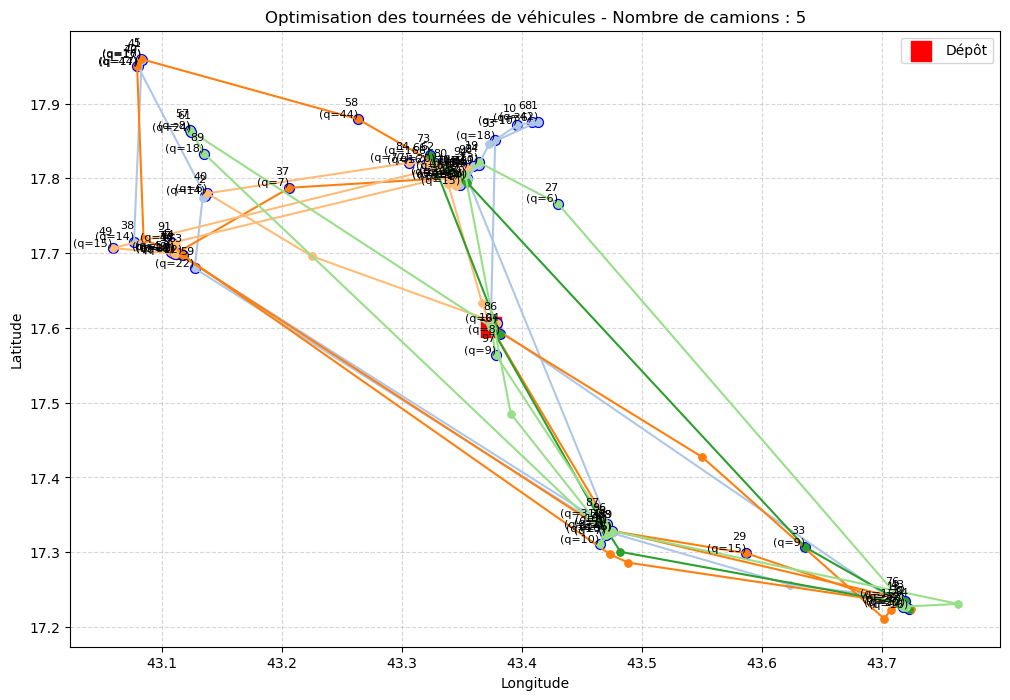

In [22]:
plot_solution(state, optimized_solution)

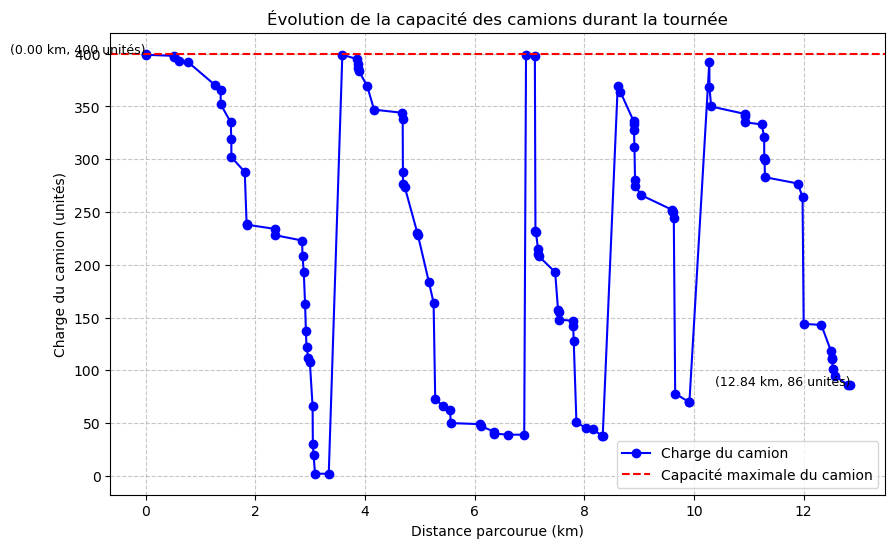

In [23]:
plot_capacity_evolution(state, optimized_solution)